In [24]:
import sys
sys.path.append(".")

In [25]:
import os

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdyn.models import NeuralODE

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Toyota-MIT-Stanford Dataset (Charge)

It contains data of LFP $LiFePO_4$ batteries cycled under fast-charging.

- Nominal Capacity : 1.1 Ah
    
- Nominal Voltage 3.3 V
    

The batteries are charged through 4 stages of fast charging to 80% SOC in constant current (CC) mode and then fully charged in CC-CV model.

- Stage 1 : 0-20%
    
- Stage 2: 20-40%
    
- Stage 3: 40-60%
    
- Stage 4: 80-100%
    

In the fourth stage, the charging rate is determined by ensuring that the total charge time of the four stages is 10 min. Then all batteries were discharged at 4 C in a CC mode.

Mostly, Input types used for prediction come from charging data since discharging is a user-specific phenomenon. These datasets are divided into 2 versions as shown below:

- Complete Charging Data:
    
    - 4 Features are Time, Voltage, Current, and Temperature.
        
    - Charging data of each cycle is divided, and all charging data resampled to fixed length of 128.
        
    - So shape of each sample is (128,4)
        
- Partial Charging Data:
    
    - Practically in industries batteries are not fully charged or discharged.
        
    - charging voltage is 3.7-4.1 V for XJTU dataset, and 3.0-3.59 V for Toyota-MIT-Stanford dataset.
        
    - Similar resampling as before to obtain (128,4)

# Visualizing Data

In [76]:
## Load the mat file
mat = loadmat("data/MIT/charge/min_batch-3.6-6-5.6-4.755.mat") #data/MIT/charge/min_batch-3.6-6-5.6-4.755.mat,  data/MIT/charge/min_batch-4.4-5.6-5.2-4.252.mat

battery_data = mat["battery"]

print("Shape of battery data:", battery_data.shape)

for i in range(battery_data.shape[1]):
    print(f"Shape of Selected Battery {i}:", battery_data[0,i][0].shape)





# for i in range(current_battery.shape[1]):
#     cycle_data = current_battery[0,i]
#     current = cycle_data["current_A"]
#     voltage = cycle_data["voltage_V"]
#     temperature = cycle_data["temperature_C"]
#     charge_cycle = np.concatenate([current, voltage, temperature], axis=0)
#     data.append(charge_cycle.T)
    
#     capacity = cycle_data["capacity"]
#     label.append(capacity.T)
    
#     print(charge_cycle.shape, capacity.shape)
#     break
# data = np.array(data, dtype=np.float32)
# label = np.array(label, dtype=np.float32)

Shape of battery data: (1, 5)
Shape of Selected Battery 0: (1, 761)
Shape of Selected Battery 1: (1, 743)
Shape of Selected Battery 2: (1, 907)
Shape of Selected Battery 3: (1, 748)
Shape of Selected Battery 4: (1, 616)


## Visualizing Per Cycle Data

In [77]:
selected_battery = battery_data[0,4][0] # Select the battery at index 4 = [0,4][0]
cycle_data = selected_battery[0,100] #Change the cycle [0,23] and is based on the shape of selected_battery

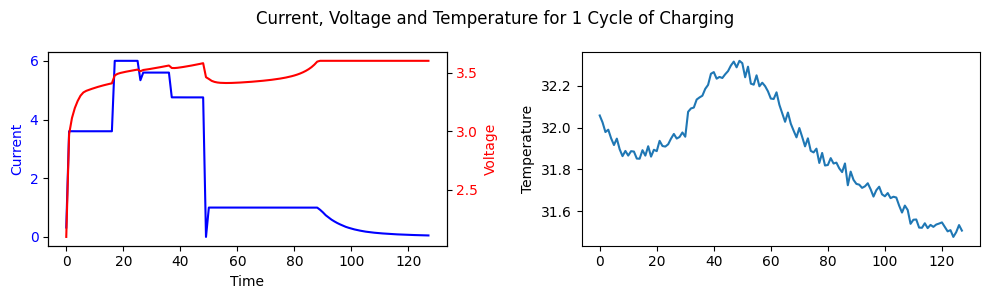

In [78]:
# Extract current, voltage, and temperature data from the cycle.
current = cycle_data["current_A"]
voltage = cycle_data["voltage_V"]
temperature = cycle_data["temperature_C"]

## Plot the data.
fig, ax = plt.subplots(1,2, figsize=(10,3))

# Plot current on the left y-axis.
ax[0].plot(current.reshape(-1,1), 'b-', label='Current')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Current', color='b')
ax[0].tick_params(axis='y', labelcolor='b')

# Create a second y-axis for voltage.
ax2 = ax[0].twinx()
ax2.plot(voltage.reshape(-1,1), 'r-', label='Voltage')
ax2.set_ylabel('Voltage', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax[1].plot(temperature.reshape(-1,1), label="Temperature")
ax[1].set_ylabel("Temperature")

plt.suptitle(f"Current, Voltage and Temperature for 1 Cycle of Charging")
fig.tight_layout()  # Adjust layout to fit both labels
plt.show()

Shape of capacity data: (616, 1)


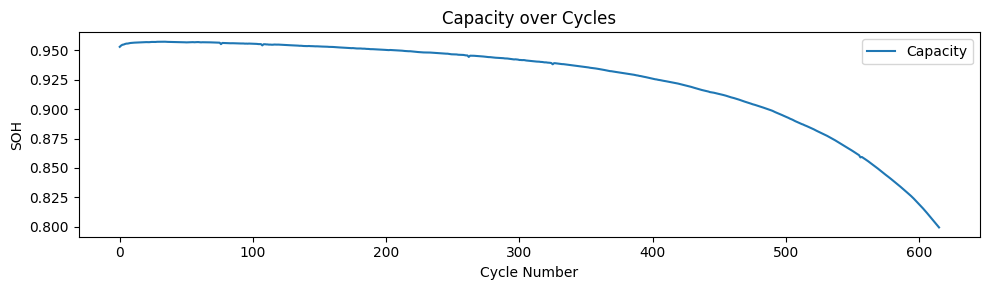

In [79]:
capacity = []

# Extract capacity data from the cycle.
for i in range(selected_battery.shape[1]):
    cycle_data = selected_battery[0,i]
    capacity.append(cycle_data["capacity"].reshape(-1,1))
capacity = np.concatenate(capacity, axis=0)

# Convert capacity to a numpy array and calculate SOH (State of Health)
soh = capacity/1.1


print("Shape of capacity data:", capacity.shape)
# Plot capacity data
plt.figure(figsize=(10, 3))
plt.plot(soh, label="Capacity")
plt.xlabel("Cycle Number")
plt.ylabel("SOH")
plt.title("Capacity over Cycles")
plt.legend()
plt.tight_layout()
plt.show()

# Build the Data

In [30]:
seq_len = 20
pred_len = 20

In [31]:
selected_battery = battery_data[0,3][0] # Select the battery at index 4 = [0,4][0]

print("Shape of selected battery data:", selected_battery.shape)

voltages = np.empty((selected_battery.shape[1], 128))
currents = np.empty((selected_battery.shape[1], 128))
temperatures = np.empty((selected_battery.shape[1], 128))
capacities = np.empty((selected_battery.shape[1], 1))

# capacity = 
cycle_data = selected_battery[0,0] #Change the cycle [0,23] and is based on the shape of selected_battery

vol = cycle_data["voltage_V"]
curr = cycle_data["current_A"]
temp = cycle_data["temperature_C"]
cap = cycle_data["capacity"]

for i in range(selected_battery.shape[1]):
    cycle_data = selected_battery[0,i]
    vol = cycle_data["voltage_V"].squeeze()
    curr = cycle_data["current_A"].squeeze()
    temp = cycle_data["temperature_C"].squeeze()
    cap = cycle_data["capacity"].squeeze()
    voltages[i,:] = vol
    currents[i,:] = curr
    temperatures[i,:] = temp
    capacities[i,:] = cap

soh = capacities/ 1.1


Shape of selected battery data: (1, 1089)


In [32]:
# print("Shape of voltages:", voltages.shape)
# print("Shape of currents:", currents.shape)
# print("Shape of temperatures:", temperatures.shape)
print("Shape of soh:", soh.shape)

voltage = np.expand_dims(voltages, axis=1)  # Add a channel dimension
current = np.expand_dims(currents, axis=1)  # Add a channel dimension
temperature = np.expand_dims(temperatures, axis=1)  # Add a channel dimension

charging_data = np.concatenate([voltage, current, temperature], axis=1)  # Concatenate along the channel dimension

charging_data = np.transpose(charging_data, (0, 2, 1))  # Transpose to shape (batch_size, channels, time_steps)
print("Shape of charging data:", charging_data.shape)
print("\n")

train_charging = charging_data[:700]  # Use the first 700 cycles for training
test_charging = charging_data[700:]  # Use the remaining cycles for testing

train_soh = soh[:700]  # Corresponding SOH for training
test_soh = soh[700:]  # Corresponding SOH for testing

# Scale the data using MinMaxScaler
sc1 = MinMaxScaler()
sc2 = MinMaxScaler()

scaled_train_charging = sc1.fit_transform(train_charging.reshape(-1, train_charging.shape[-1])).reshape(train_charging.shape)
scaled_test_charging = sc1.transform(test_charging.reshape(-1, test_charging.shape[-1])).reshape(test_charging.shape)
scaled_train_soh = sc2.fit_transform(train_soh)
scaled_test_soh = sc2.transform(test_soh)

print("Shape of scaled training charging data:", scaled_train_charging.shape)
print("Shape of scaled training SOH data:", scaled_train_soh.shape)
print("Shape of scaled testing charging data:", scaled_test_charging.shape)
print("Shape of scaled testing SOH data:", scaled_test_soh.shape)

# Convert to PyTorch tensors
# scaled_train_charging = torch.tensor(scaled_train_charging, dtype=torch.float32)
# scaled_train_soh = torch.tensor(scaled_train_soh, dtype=torch.float32)
# scaled_test_charging = torch.tensor(scaled_test_charging, dtype=torch.float32)
# scaled_test_soh = torch.tensor(scaled_test_soh, dtype=torch.float32)


Shape of soh: (1089, 1)
Shape of charging data: (1089, 128, 3)


Shape of scaled training charging data: (700, 128, 3)
Shape of scaled training SOH data: (700, 1)
Shape of scaled testing charging data: (389, 128, 3)
Shape of scaled testing SOH data: (389, 1)


In [52]:
seq_len = 20
pred_len = 20

In [53]:
def create_dataset(charging_data, soh_data, time_step=20, pred_len=20):
    """
    charging_data: np.array of shape (N, 128, 3)
    soh_data: np.array of shape (N, 1)
    """
    X_charge, X_soh, y_soh = [], [], []

    total_steps = time_step + pred_len
    for i in range(len(charging_data) - total_steps + 1):
        X_charge.append(charging_data[i:i+time_step])            # (time_step, 128, 3)
        X_soh.append(soh_data[i:i+time_step, 0])                  # (time_step,)
        y_soh.append(soh_data[i+time_step:i+time_step+pred_len, 0])  # (pred_len,)

    return np.array(X_charge), np.array(X_soh), np.array(y_soh)


## Create the dataset for training
X_charge_train, X_soh_train, y_soh_train = create_dataset(
    scaled_train_charging, scaled_train_soh, time_step=seq_len, pred_len=pred_len
) 

print("Shape of X_charge_train:", X_charge_train.shape)
print("Shape of X_soh_train:", X_soh_train.shape)
print("Shape of y_soh_train:", y_soh_train.shape)
print("\n")

## Create the dataset for testing
X_charge_test, X_soh_test, y_soh_test = create_dataset(
    scaled_test_charging, scaled_test_soh, time_step=seq_len, pred_len=pred_len
)
print("Shape of X_charge_test:", X_charge_test.shape)
print("Shape of X_soh_test:", X_soh_test.shape)
print("Shape of y_soh_test:", y_soh_test.shape)


Shape of X_charge_train: (661, 20, 128, 3)
Shape of X_soh_train: (661, 20)
Shape of y_soh_train: (661, 20)


Shape of X_charge_test: (350, 20, 128, 3)
Shape of X_soh_test: (350, 20)
Shape of y_soh_test: (350, 20)


In [54]:
# Convert to tensors
X_charge_train_tensor = torch.tensor(X_charge_train, dtype=torch.float32)  # (661, 20, 128, 3)
X_soh_train_tensor = torch.tensor(X_soh_train, dtype=torch.float32)        # (661, 20)
y_soh_train_tensor = torch.tensor(y_soh_train, dtype=torch.float32) 
# (661, 20)

train_dataset = TensorDataset(X_charge_train_tensor, X_soh_train_tensor, y_soh_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


X_charge_test_tensor = torch.tensor(X_charge_test, dtype=torch.float32)  # (350, 20, 128, 3)
X_soh_test_tensor = torch.tensor(X_soh_test, dtype=torch.float32)        # (350, 20)
y_soh_test_tensor = torch.tensor(y_soh_test, dtype=torch.float32)        # (350, 20)

test_dataset = TensorDataset(X_charge_test_tensor, X_soh_test_tensor, y_soh_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch_size=1 for prediction/plotting

# Define Model

If we are provided with L SOH + charging data, can we predict the next H SOH.

$$ SOH_{L+1:L+H} = P_1 SOH_1 + P_2 SOH_2 + \dots + P_L SOH_L + Q_1 C_1 + Q_2 C_2 + \dots + Q_L C_L + B $$


where,

$$ C_i = g(X)$$

- $SOH_i \in \mathbb{R}$. This is a MLP Model.
- $C_i \in \mathbb{R}$ is the charge value per cycle based on $X$. This is a GRU Model.
- $X \in \mathbb{R}^{128 \times 3}$ which represents the voltage, current, and temperature data per cycle.

Since X is sequential CC-CV charging, we use GRU to get C_i output per charging cycle.





In [55]:
class ChargingPredictor(nn.Module):
    '''
    It models x(t) = g(V(t), I(t), T(t))) for one battery cycle.
    '''
    def __init__(self, input_dim=3, hidden_dim=32, num_layers=1):
        super(ChargingPredictor, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, 1)


    def forward(self, x):
        # x shape: (batch_size, seq_len=128, input_dim=3)
        out, _ = self.gru(x)            # out: (batch_size, 128, 3)
        last_hidden = out[:, -1, :]     # Use the last time step
        x_pred = self.fc(last_hidden)   # (batch_size, 1)
        return x_pred.squeeze(-1)       # (batch_size,)


In [56]:
class SOHpredictor(nn.Module):
    def __init__(self, seq_len=20, pred_len=20):  # <-- fix here
        super(SOHpredictor, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        self.charge = ChargingPredictor(input_dim=3, hidden_dim=32, num_layers=1)
        self.ffn = nn.Sequential(
            nn.Linear(2 * self.seq_len, 32),
            nn.ReLU(),
            nn.Linear(32, self.pred_len)
        )

    def forward(self, soh, c):
        # soh: (batch_size, seq_len)
        # c: (batch_size, seq_len, 128, 3)

        batch_size = c.size(0)

        # Flatten for batch processing: (batch_size * seq_len, 128, 3)
        c_flat = c.view(-1, c.size(2), c.size(3))

        # Run through charging GRU model
        charge_flat = self.charge(c_flat)  # (batch_size * seq_len,)

        # Reshape back to (batch_size, seq_len)
        charge_val = charge_flat.view(batch_size, self.seq_len)

        # Concatenate the SOH and charge values
        combined = torch.cat((soh, charge_val), dim=1)  # (batch_size, 2 * seq_len)

        output = self.ffn(combined)  # (batch_size, pred_len)
        return output

# Initialize the model
model = SOHpredictor(seq_len=seq_len, pred_len=pred_len)

In [57]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30



In [58]:
best_loss = float('inf')
checkpoint_path = 'checkpoints/checkpoint.pth' 

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for charging_input, soh_input, soh_output in train_loader:
        output = model(soh_input, charging_input)
        loss = criterion(output, soh_output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)

    # Save best model if loss improves
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [5/30], Loss: 0.4109
Epoch [10/30], Loss: 0.1070
Epoch [15/30], Loss: 0.0417
Epoch [20/30], Loss: 0.0176
Epoch [25/30], Loss: 0.0079
Epoch [30/30], Loss: 0.0047


# Test Predicting

In [59]:
#Load the best model
# Load the checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()  # Set to evaluation mode

SOHpredictor(
  (charge): ChargingPredictor(
    (gru): GRU(3, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=1, bias=True)
  )
  (ffn): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=20, bias=True)
  )
)

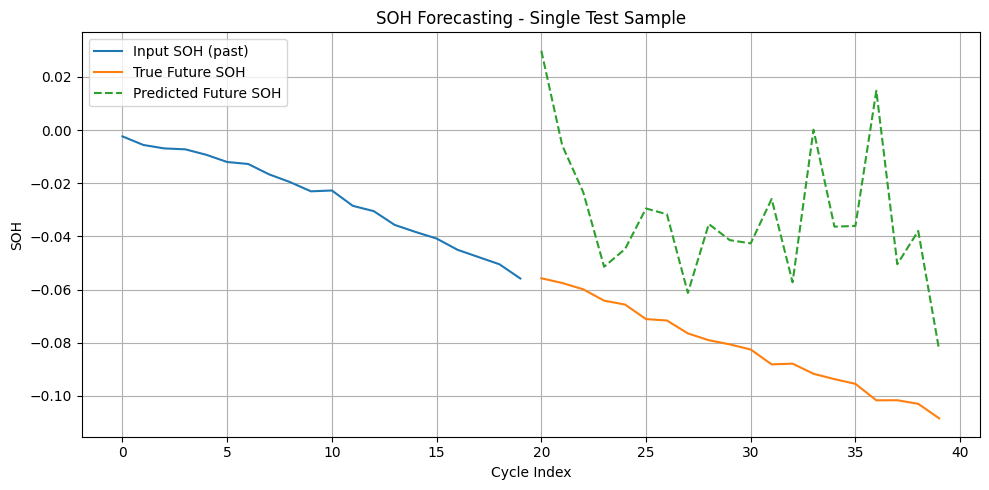

In [60]:
with torch.no_grad():
    for charging_input, soh_input, soh_target in test_loader:
        prediction = model(soh_input, charging_input)  # shape: (1, 20)
        break  # Only first sample

# Convert to numpy
soh_input_np = soh_input.numpy().flatten()     # (20,)
true_np = soh_target.numpy().flatten()         # (20,)
pred_np = prediction.numpy().flatten()         # (20,)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(20), soh_input_np, label="Input SOH (past)")
plt.plot(range(20, 40), true_np, label="True Future SOH")
plt.plot(range(20, 40), pred_np, label="Predicted Future SOH", linestyle='--')
plt.xlabel("Cycle Index")
plt.ylabel("SOH")
plt.title("SOH Forecasting - Single Test Sample")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()   